In [1]:
# !pip install opencv-python
# !pip install matplotlib
# !pip install Flask pyngrok opencv-python-headless matplotlib
# !pip install tensorflow
# !pip install --upgrade tensorflow
# !pip install h5py
# !pip install paddlepaddle paddleocr
# !pip install mtcnn
# !pip install paddleocr
# !pip install "fastapi[standard]"
print("Installed all required packages")

Installed all required packages


In [2]:
from paddleocr import PaddleOCR
import re
import cv2
import numpy as np
import os
from flask import Flask, request, jsonify
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, metrics
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from werkzeug.utils import secure_filename
from mtcnn import MTCNN
from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import JSONResponse

In [3]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )

    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [4]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                  

In [5]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [6]:
siamese_model = SiameseModel(siamese_network)
siamese_model.built = True
siamese_model.load_weights('siamese_model_weights.h5')
optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

siamese_model.summary()

Model: "siamese_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Siamese_Network (Functional  ((None,),                22043944  
 )                            (None,))                           
                                                                 
Total params: 22,043,946
Trainable params: 9,583,800
Non-trainable params: 12,460,146
_________________________________________________________________


In [7]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                      

In [8]:
# app = Flask(__name__)

app = FastAPI()

In [9]:
UPLOAD_FOLDER = 'uploads'
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

In [10]:
ocr = PaddleOCR(use_angle_cls=True, lang='vi', rec=True, det=True)

[2024/12/31 23:58:45] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\phanh/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\phanh/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batc

In [11]:
mtcnn = MTCNN()

In [12]:
def extract_mssv_from_image(image_path):
    result = ocr.ocr(image_path, cls=True)

    if result == [None]:
        return "Normal image"

    detected_text = ""
    for line in result[0]:
        detected_text += line[1][0] + " "  

    mssv_pattern = r'MSSV:\s*(\d+[A-Za-z]+\d+)'  
    match = re.search(mssv_pattern, detected_text)

    if match:
        return match.group(1)  
    else:
        return "MSSV not found"  

In [13]:
def detect_and_preprocess(image_path):
    img = cv2.imread(image_path)
    
    faces = mtcnn.detect_faces(img)  
    
    if len(faces) == 0:
        return None, "No face detected", None
    

    x, y, w, h = faces[0]['box']
    face = img[int(y):int(y+h), int(x):int(x+w)]

    face_resized = cv2.resize(face, (128, 128))
    face_normalized = face_resized / 255.0
    return np.expand_dims(face_normalized, axis=0), None, face


In [14]:
@app.post("/compare")
async def compare_faces(image1: UploadFile = File(...), image2: UploadFile = File(...)):
    # if 'image1' not in request.files or 'image2' not in request.files:
    #     return jsonify({'error': 'Both image1 and image2 must be provided.'}), 400

    # # Save uploaded images
    # image1 = request.files['image1']
    # image2 = request.files['image2']

    # filename1 = secure_filename(image1.filename)
    # filepath1 = os.path.join(app.config['UPLOAD_FOLDER'], filename1)
    # image1.save(filepath1)

    # filename2 = secure_filename(image2.filename)
    # filepath2 = os.path.join(app.config['UPLOAD_FOLDER'], filename2)
    # image2.save(filepath2)
    # Save the uploaded images
    filename1 = secure_filename(image1.filename)
    filepath1 = os.path.join(UPLOAD_FOLDER, filename1)
    with open(filepath1, "wb") as buffer:
        buffer.write(await image1.read())

    filename2 = secure_filename(image2.filename)
    filepath2 = os.path.join(UPLOAD_FOLDER, filename2)
    with open(filepath2, "wb") as buffer:
        buffer.write(await image2.read())

    img1, error1, cropped_face1 = detect_and_preprocess(filepath1)
    img2, error2, cropped_face2 = detect_and_preprocess(filepath2)

    sid1 = extract_mssv_from_image(filepath1)
    sid2 = extract_mssv_from_image(filepath2)

    # Clean up uploaded files
    os.remove(filepath1)
    os.remove(filepath2)

    # Check for detection errors
    if error1:
        return jsonify({'error': f'Image1: {error1}'}), 400
    if error2:
        return jsonify({'error': f'Image2: {error2}'}), 400

    embedding1 = encoder.predict(img1)
    embedding2 = encoder.predict(img2)

    threshold = 1.3
    distance = np.sum(np.square(embedding1 - embedding2), axis=-1)

    confidence = max(0, 100 * (1 - distance / threshold))

    prediction = 0 if distance <= threshold else 1

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(cropped_face1, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Cropped Image 1")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(cropped_face2, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Cropped Image 2")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


    return  JSONResponse(content={
        'prediction': int(prediction),
        'confidence': round(float(confidence), 2),
        'student_id_1': sid1,  
        'student_id_2': sid2   
    })

In [15]:
@app.post("/getMSSV")
async def get_mssv(image1: UploadFile = File(...)):
    try:
        # Save the uploaded image
        filename1 = secure_filename(image1.filename)
        filepath1 = os.path.join(UPLOAD_FOLDER, filename1)

        with open(filepath1, "wb") as buffer:
            buffer.write(await image1.read())

        # Process image (face detection, extraction, etc.)
        img1, error1, cropped_face1 = detect_and_preprocess(filepath1)

        # Extract MSSV from image
        sid1 = extract_mssv_from_image(filepath1)

        # Clean up uploaded files after processing
        os.remove(filepath1)

        # Check for detection errors
        if error1:
            raise HTTPException(status_code=400, detail=f"Image1: {error1}")

        # Check if MSSV was found
        if sid1 == "MSSV not found":
            raise HTTPException(status_code=400, detail="MSSV not found")

        # Return the result
        print(f'student_id_1: {sid1}')
        return JSONResponse(content={'student_id_1': sid1})

    except Exception as e:
        raise HTTPException(status_code=500, detail=f"An error occurred: {str(e)}")

In [16]:
@app.get("/")
async def test():
    return JSONResponse(content={"success": True})

INFO:     Started server process [4300]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


1/1 [==============================] - 0s 45ms/step
[2024/12/31 23:58:56] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.49197816848754883
[2024/12/31 23:58:56] ppocr DEBUG: cls num  : 26, elapsed : 0.12151384353637695
[2024/12/31 23:58:57] ppocr DEBUG: rec_res num  : 26, elapsed : 0.43057751655578613
[2024/12/31 23:58:57] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.26918506622314453
[2024/12/31 23:58:57] ppocr DEBUG: cls num  : 0, elapsed : 0
[2024/12/31 23:58:57] ppocr DEBUG: rec_res num  : 0, elapsed : 0.0
1/1 [==============================] - 0s 21ms/step


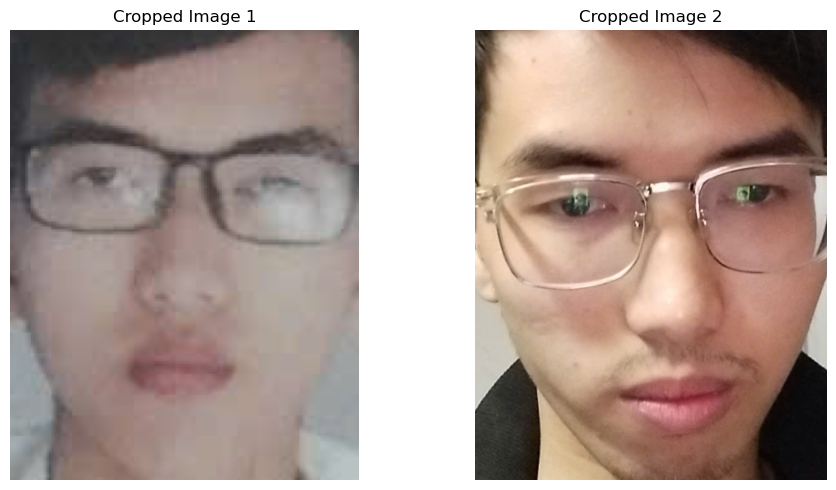

INFO:     127.0.0.1:54515 - "POST /compare HTTP/1.1" 200 OK
1/1 [==============================] - 0s 17ms/step
[2024/12/31 23:59:07] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.0900118350982666
[2024/12/31 23:59:07] ppocr DEBUG: cls num  : 26, elapsed : 0.04358839988708496
[2024/12/31 23:59:07] ppocr DEBUG: rec_res num  : 26, elapsed : 0.20684123039245605
student_id_1: 521H0453
INFO:     127.0.0.1:54534 - "POST /getMSSV HTTP/1.1" 200 OK
INFO:     127.0.0.1:54893 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:54893 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:55108 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:55108 - "GET /flutter_service_worker.js?v=4157212501 HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:55109 - "GET /flutter_service_worker.js?v=4157212501 HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:55169 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:55169 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:55217 - "GET / HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [4300]


In [17]:
import nest_asyncio
import uvicorn
if __name__ == "__main__":
    # Expose the FastAPI app via ngrok
    # public_url = ngrok.connect(5000)
    # print(f"FastAPI app running at {public_url}")
    
    nest_asyncio.apply()
    uvicorn.run(app, host="192.168.8.129", port=8000)